In [3]:
%matplotlib inline
import pylab as plt
from blimpy import Waterfall
import numpy as np
from scipy import interpolate
import peakutils
import rfi
import turbo_seti
import pandas as pd
import BaselineRemoval
import scipy
import os
from astropy.time import Time
from astropy import units as u
import matplotlib
import time
from collections import Counter

In [6]:
path='data/59074/'
files=os.listdir(path)
#files.remove('.ipynb_checkpoints')
len(files)

29

In [ ]:
wf=[]
j=0
for i in files:
    #print(j)
    wf.append(Waterfall(path+i))
    j+=1
name=[]
j=0
for i in wf:
    name.append([i.container.f_stop-i.container.f_start,files[j]])
    j+=1
name.sort(reverse=True)
wf=[]
for i in name:
    wf.append(Waterfall(path+i[1]))
# for i in wf:
#     print(i.container.f_start)

In [ ]:
for i in wf:
    print(i.container.f_start,i.container.f_stop)

In [3]:
wf=[]
j=0
for i in files:
    #print(j)
    wf.append(Waterfall(path+i))
    j+=1
time_order=[]
for i in wf:
    time_order.append([i.file_header.get('tstart'),i])
time_order.sort()
wf=[]
for i in time_order:
    wf.append(i[1])

In [10]:
a=0
b=0
c=0
for i in data['RFI(MHz)']:
    for j in i:
        if ((j[0]>880)&(j[0]<970)) or ((j[1]>880)&(j[1]<970)):
            a+=1
            break
for i in data['RFI(MHz)']:
    for j in i:
        if ((j[0]>1120)&(j[0]<1300)) or ((j[1]>1120)&(j[1]<1300)):
            b+=1
            break
for i in data['RFI(MHz)']:
    for j in i:
        if ((j[0]>1400)&(j[0]<1610)) or ((j[1]>1400)&(j[1]<1610)):
            c+=1
            break
print(a,b,c)

43 33 29


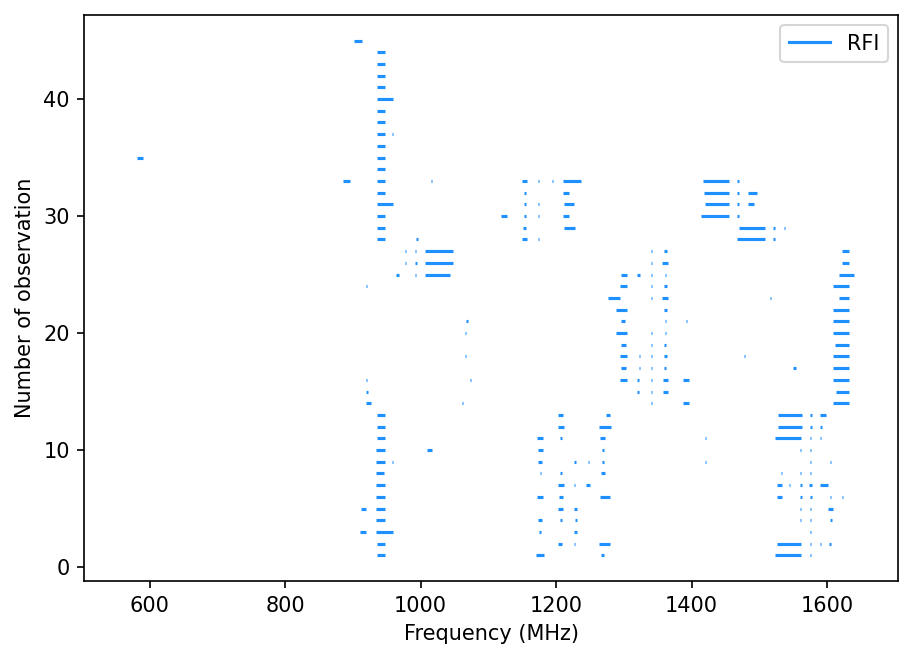

In [14]:
j=1
plt.figure(figsize=(7,5),dpi=150)
for i in data['RFI(MHz)']:
    for k in i:
        plt.hlines(j,k[0],k[1],color='dodgerblue')
    j+=1
plt.plot([],[],color='dodgerblue',label='RFI')
# plt.vlines(880,0,50,'dodgerblue',linestyles='--')
# plt.vlines(960,0,50,'dodgerblue',linestyles='--')
# plt.vlines(1120,0,28,'dodgerblue',linestyles='--')
# plt.vlines(1300,0,28,'dodgerblue',linestyles='--')
# plt.vlines(1400,0,28,'dodgerblue',linestyles='--')
# plt.vlines(1610,0,28,'dodgerblue',linestyles='--')
# plt.bar(700,50,width=312,color='w',hatch='/',label='UHF-band')
# plt.bar(972,50,width=232,color='w',hatch='X',label='UHF and L overlap')
# plt.bar(1400,50,width=624,color='w',hatch="\\",label='L-band')
# plt.text(900,50,str(a)+' obs')
# plt.text(1190,28,str(b)+' obs')
# plt.text(1490,28,str(c)+' obs')
plt.ylabel('Number of observation')
plt.xlabel('Frequency (MHz)')
plt.legend()
plt.savefig('plots/after_mid/RFI_vs_File_BR.pdf')

In [27]:
start=time.time()
j=1
multi=0.8
plt.figure(figsize=(10,4*len(wf)),dpi=100)
for i in wf:
    plt.subplot(len(wf),1,j)
    if j in np.arange(14,28,1):
        f,p,base=rfi.base(i,flip=True)
        test=rfi.intersection(i,multi=multi,flip=True)
        plt.text(1128,np.amax(p)*multi/55,'Flipped',color='r')
    else:
        f,p,base=rfi.base(i)
        test=rfi.intersection(i,multi=multi)
    plt.plot(f,p,'k',label='Power')
    plt.plot(f,base,'r--',label='Baseline')
    plt.vlines(test,0,np.amax(p),'lime')
    thres=(p-base).std()*multi/10
    plt.plot(f,base+thres,label='Threshold')
    if i.container.f_start>=856.0:
        plt.text(1128,np.amax(p)*multi/50,'L-Band at '+Time(i.file_header.get('tstart'), format='mjd').isot+' from '+i.header['source_name'],size=5,ha='center',fontsize=10)
    else:
        plt.text(1128,np.amax(p)*multi/50,'UHF-Band at '+Time(i.file_header.get('tstart'), format='mjd').isot+' from '+i.header['source_name'],size=5,ha='center',fontsize=10)
    plt.gca().xaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(20))
    plt.grid()
    plt.grid(which='minor',color='whitesmoke')
    plt.xlim(544,1712)
    plt.ylim(-100,np.amax(p)*multi/50)
    plt.legend()
    j+=1
plt.savefig('plots/after_mid/all_fitting_BR.pdf',bbox_inches = 'tight')
plt.close()
end=time.time()
print('This takes '+str(end-start)+' (s)')

This takes 28.462562561035156 (s)


In [ ]:
data=pd.DataFrame()
data['source_name']=[]
data['time(MJD)']=[]
data['src_raj']=[]
data['f_range(MHz)']=[]
data['RFI(MHz)']=[]
for i in wf:
    f,p,b=rfi.base(i)
    maxi=np.amax(i.get_power()[1])
    multi=0.8
    if maxi>10000:
        multi=multi/10
    a=i.header['source_name']
    b=MJD_time(i)
    c=i.header['src_raj']
    d=(f[0],f[-1])
    e=rfi.rfi_range(i,multi=multi)
    data.loc[j]=[a,b,c,d,e]
    j+=1
#data=data.drop(labels='index')
data=data.reset_index()

In [11]:
data.to_csv('part_1.csv',index=False)

In [31]:
j=1
multi=0.8
plt.figure(figsize=(10,7),dpi=75)
for i in wf[-7:]:
    plt.subplot(len(wf[-7:]),1,j)
    f,p,base=rfi.base(i)
    test=rfi.intersection(i,multi=multi)
    if j in range(2,8):
        index=np.where(f>1100)
        f[index]=f[index]+250*i.header['foff']
        index2=np.where(test>1100)
        test[index2]=test[index2]+250*i.header['foff']
    if j in range(3,7):
        index=np.where(f>1350)
        f[index]=f[index]+250*i.header['foff']
        index2=np.where(test>1350)
        test[index2]=test[index2]+250*i.header['foff']
    plt.plot(f,p,'k',label='Observed')
    plt.plot(f,base,color='#e6e600',linestyle='--',label='Fitted')
    plt.vlines(test,0,np.amax(p),'#e6b8e6',label='RFI')
    thres=(p-base).std()*multi/10
    plt.plot(f,base+thres,'#00e6e6',label='Threshold')
    if i.container.f_start>=856.0:
        plt.text(1284,np.amax(p)*multi/50,'L-Band at '+Time(i.file_header.get('tstart'), format='mjd').isot+' from '+i.header['source_name'],size=5,ha='center',fontsize=10)
    else:
        plt.text(1284,np.amax(p)*multi/50,'UHF-Band at '+Time(i.file_header.get('tstart'), format='mjd').isot+' from '+i.header['source_name'],size=5,ha='center',fontsize=10)
    plt.gca().xaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(20))
    plt.grid()
    plt.grid(which='minor',color='whitesmoke')
    plt.xlim(900,1712)
    plt.ylim(-100,np.amax(p)*multi/50)
    plt.ylabel('Power[counts]',fontsize=7)
#     if j==1:
#         plt.legend(fontsize=7)
#     if j!=5:
#         plt.xticks(visible=False)
#     if j==5:
#         plt.xlabel('Frequency(MHz)')
    j+=1
plt.savefig('plots/after_mid/Shift.pdf',bbox_inches = 'tight')
plt.close()

In [25]:
6 in range(3,7)

True

In [25]:
j=1
plt.figure(figsize=(10,4*len(wf[:31])),dpi=150)
for i in wf[:31]:
    plt.subplot(len(wf[:31]),1,j)
    i.plot_waterfall()
    plt.title(str(j))
    plt.xlabel('')
    #plt.ylim(-100,np.amax(i.get_power()[1])/20)
    j+=1
plt.savefig('test1.pdf',bbox_inches='tight')
plt.close()

In [13]:
j=1
for i in wf:
    if i.container.f_start==856.0:
        j+=1
        
print(j)

31


In [7]:
need_to_flip=[]
for i in wf[13:27]:
    need_to_flip.append(i)
need_to_flip

[Waterfall data: data/BR/guppi_58934_66353_005001_Unknown_0001-ics.rawspec.0000.combined.fil,
 Waterfall data: data/BR/guppi_58934_65844_004976_Unknown_0001-ics.rawspec.0000.combined.fil,
 Waterfall data: data/BR/guppi_58934_65804_004974_Unknown_0001-ics.rawspec.0000.combined.fil,
 Waterfall data: data/BR/guppi_58934_64879_004928_Unknown_0001-ics.rawspec.0000.combined.fil,
 Waterfall data: data/BR/guppi_58934_64474_004908_Unknown_0001-ics.rawspec.0000.combined.fil,
 Waterfall data: data/BR/guppi_58934_64435_004906_Unknown_0001-ics.rawspec.0000.combined.fil,
 Waterfall data: data/BR/guppi_58934_63353_004852_Unknown_0001-ics.rawspec.0000.combined.fil,
 Waterfall data: data/BR/guppi_58934_63309_004850_Unknown_0001-ics.rawspec.0000.combined.fil,
 Waterfall data: data/BR/guppi_58934_62544_004811_Unknown_0001-ics.rawspec.0000.combined.fil,
 Waterfall data: data/BR/guppi_58934_62505_004810_Unknown_0001-ics.rawspec.0000.combined.fil,
 Waterfall data: data/BR/guppi_58934_61159_004742_Unknown_00

In [7]:
for i in wf[:5]:
    

True

(array([-10.,   0.,  10.,  20.,  30.,  40.,  50.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

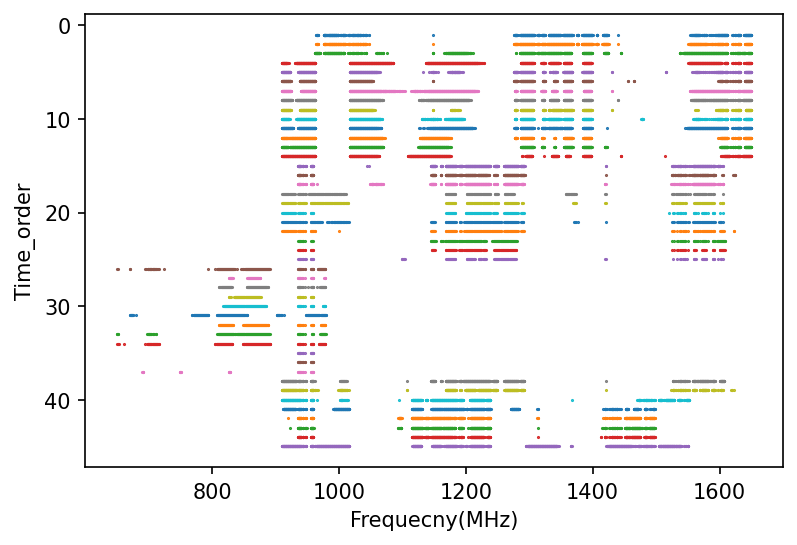

In [41]:
j=1
plt.figure(dpi=150)
for i in wf:
    maxi=np.amax(i.get_power()[1])
    multi=2.5
    if maxi>10000:
        multi=multi/10
#     if j in np.arange(0,14,1):
#         fi=rfi.intersection(i,multi=multi,flip=True)
#     else:
#         fi=rfi.intersection(i,multi=multi)
    fi=rfi.intersection(i,multi=multi)
    if j in np.arange(0,14,1):
        fi=np.flip(fi)
    y=np.zeros(fi.shape)
    y=np.where(y==0,j,y)
    plt.scatter(fi,y,s=0.25)
    j+=1
# line=[[650,660],[700,720],[840,880],[930,960],[1020,1050],[1160,1240],[1300,1380],[1560,1600]]
# for i in line[:4]:
#     plt.bar((i[1]+i[0])/2,80,width=i[1]-i[0],color='w',edgecolor='k',hatch='/',alpha=0.25)
# for i in line[4:]:
#     plt.bar((i[1]+i[0])/2,35,width=i[1]-i[0],color='w',edgecolor='k',hatch='/',alpha=0.25)
plt.gca().invert_yaxis()
plt.xlabel('Frequecny(MHz)')
plt.ylabel('Time_order')
plt.yticks()
# plt.gca().xaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(20))
# plt.grid()
# plt.grid(which='minor',color='whitesmoke')

In [89]:
wf_l=[]
wf_uhf=[]
for i in wf:
    if i.container.f_start!=544.0:
        wf_l.append(i)
    else:
        wf_uhf.append(i)
l_yticks=[]
for i in wf_l:
    if (Time(i.file_header.get('tstart'), format='mjd').isot)[:10] not in l_yticks:
        l_yticks.append((Time(i.file_header.get('tstart'), format='mjd').isot)[:10])
uhf_yticks=[]
for i in wf_uhf:
    if (Time(i.file_header.get('tstart'), format='mjd').isot)[:10] not in uhf_yticks:
        uhf_yticks.append((Time(i.file_header.get('tstart'), format='mjd').isot)[:10])
l_yloc=[0]
new_wf=[]
for i in wf_l:
    new_wf.append(Time(i.file_header.get('tstart'), format='mjd').isot[:10])
test_y=Counter(new_wf)
for key,value in test_y.items():
    l_yloc.append(value+l_yloc[-1])
l_yloc.pop()
uhf_yloc=[0]
new_wf=[]
for i in wf_uhf:
    new_wf.append(Time(i.file_header.get('tstart'), format='mjd').isot[:10])
test_y=Counter(new_wf)
for key,value in test_y.items():
    uhf_yloc.append(value+uhf_yloc[-1])
uhf_yloc.pop()
uhf_yloc

[0, 3]

In [85]:
l_yticks

['2020-03-26', '2020-04-08', '2020-07-16']

Text(0.5, 1.0, 'L-band')

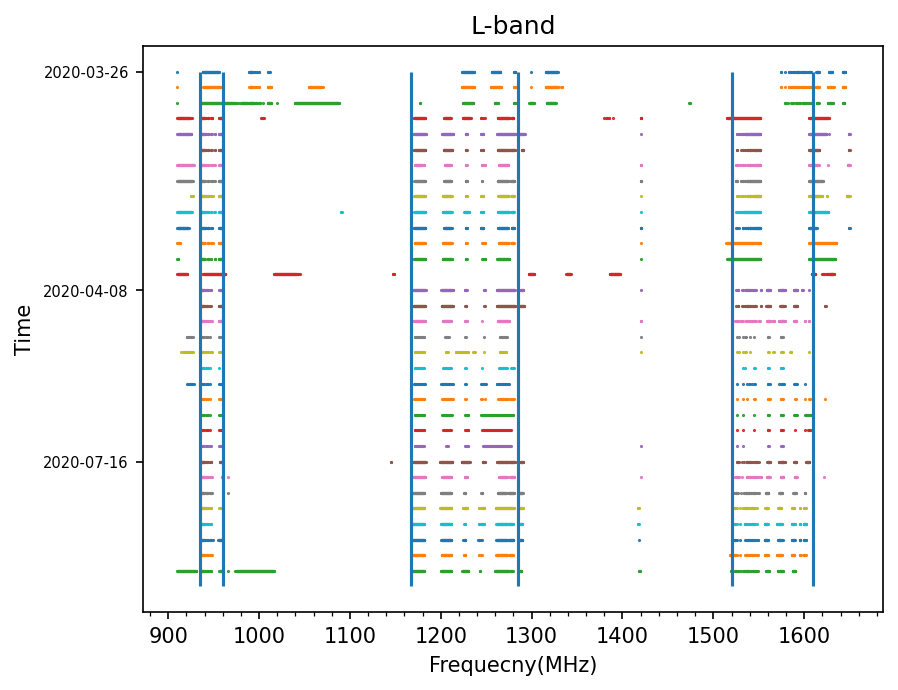

In [112]:
j=1
plt.figure(figsize=(14,5),dpi=150)
plt.subplot(1,2,1)
for i in wf_l:
    maxi=np.amax(i.get_power()[1])
    multi=1.0
#     if maxi>10000:
#         multi=multi/10
    if j in np.arange(0,14,1):
        fi=rfi.intersection(i,multi=multi,flip=True)
    else:
        fi=rfi.intersection(i,multi=multi)
#     fi=rfi.intersection(i,multi=multi)
#     if j in np.arange(0,14,1):
#         fi=np.flip(fi)
    if j in range(28,34):
        index=np.where(fi>1100)
        fi[index]=fi[index]+250*i.header['foff']
    if j in range(29,33):
        index=np.where(fi>1350)
        fi[index]=fi[index]+250*i.header['foff']
    y=np.zeros(fi.shape)
    y=np.where(y==0,j-1,y)
    plt.scatter(fi,y,s=0.25)
    j+=1
# line=[[650,660],[700,720],[840,880],[930,960],[1020,1050],[1160,1240],[1300,1380],[1560,1600]]
# for i in line[:4]:
#     plt.bar((i[1]+i[0])/2,80,width=i[1]-i[0],color='w',edgecolor='k',hatch='/',alpha=0.25)
# for i in line[4:]:
#     plt.bar((i[1]+i[0])/2,35,width=i[1]-i[0],color='w',edgecolor='k',hatch='/',alpha=0.25)
vlines=[935,960,1167,1285,1520,1610]
plt.vlines(vlines,0,33)
plt.gca().xaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(20))
plt.gca().invert_yaxis()
plt.xlabel('Frequecny(MHz)')
plt.ylabel('Time')
plt.yticks(ticks=l_yloc,labels=l_yticks,fontsize=7)
plt.title('L-band')
# plt.gca().xaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(20))
# plt.grid()
# plt.grid(which='minor',color='whitesmoke')
# plt.subplot(1,2,2)
# j=1
# for i in wf_uhf:
#     maxi=np.amax(i.get_power()[1])
#     multi=1.0
#     fi=rfi.intersection(i,multi=multi)
#     y=np.zeros(fi.shape)
#     y=np.where(y==0,j-1,y)
#     plt.scatter(fi,y,s=0.25)
#     j+=1
# # line=[[650,660],[700,720],[840,880],[930,960],[1020,1050],[1160,1240],[1300,1380],[1560,1600]]
# # for i in line[:4]:
# #     plt.bar((i[1]+i[0])/2,80,width=i[1]-i[0],color='w',edgecolor='k',hatch='/',alpha=0.25)
# # for i in line[4:]:
# #     plt.bar((i[1]+i[0])/2,35,width=i[1]-i[0],color='w',edgecolor='k',hatch='/',alpha=0.25)
# plt.gca().invert_yaxis()
# plt.gca().xaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(20))
# plt.xlabel('Frequecny(MHz)')
# plt.yticks(ticks=uhf_yloc,labels=uhf_yticks,fontsize=7)
# plt.title('UHF-band')
# # plt.gca().xaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(20))
# # plt.grid()
# # plt.grid(which='minor',color='whitesmoke')

(array([-2.,  0.,  2.,  4.,  6.,  8., 10., 12., 14.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

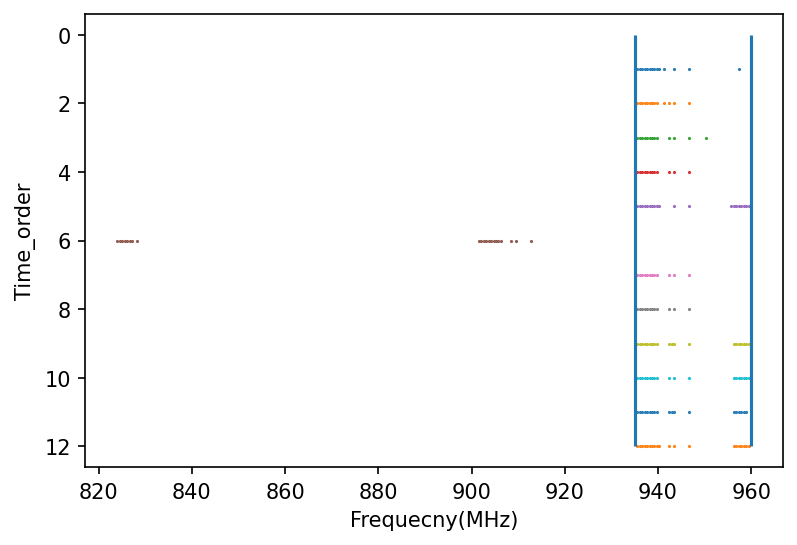

In [109]:
j=1
plt.figure(dpi=150)
for i in wf_uhf:
    maxi=np.amax(i.get_power()[1])
    multi=1.0
    fi=rfi.intersection(i,multi=multi)
    y=np.zeros(fi.shape)
    y=np.where(y==0,j,y)
    plt.scatter(fi,y,s=0.25)
    j+=1
# line=[[650,660],[700,720],[840,880],[930,960],[1020,1050],[1160,1240],[1300,1380],[1560,1600]]
# for i in line[:4]:
#     plt.bar((i[1]+i[0])/2,80,width=i[1]-i[0],color='w',edgecolor='k',hatch='/',alpha=0.25)
# for i in line[4:]:
#     plt.bar((i[1]+i[0])/2,35,width=i[1]-i[0],color='w',edgecolor='k',hatch='/',alpha=0.25)
plt.vlines([935,960],0,12)
plt.gca().invert_yaxis()
plt.gca().xaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(20))
plt.xlabel('Frequecny(MHz)')
plt.ylabel('Time_order')
plt.yticks()
# plt.gca().xaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(20))
# plt.grid()
# plt.grid(which='minor',color='whitesmoke')

In [77]:
j=1
multi=1.0
plt.figure(figsize=(10,4*len(wf_l)),dpi=100)
for i in wf_l:
    plt.subplot(len(wf_l),1,j)
    if j in np.arange(0,15,1):
        f,p,base=rfi.base(i,flip=True)
        test=rfi.intersection(i,multi=multi,flip=True)
        plt.text(1128,np.amax(p)*multi/55,'Flipped',color='r')
    else:
        f,p,base=rfi.base(i)
        test=rfi.intersection(i,multi=multi)
    plt.plot(f,p,'k',label='Power')
    plt.plot(f,base,'r--',label='Baseline')
    plt.vlines(test,0,np.amax(p),'lime')
    thres=(p-base).std()*multi/10
    plt.plot(f,base+thres,label='Threshold')
    if i.container.f_start>=856.0:
        plt.text(1128,np.amax(p)*multi/50,'L-Band at '+Time(i.file_header.get('tstart'), format='mjd').isot+' from '+i.header['source_name']+' '+str(j),size=5,ha='center',fontsize=10)
    else:
        plt.text(1128,np.amax(p)*multi/50,'UHF-Band at '+Time(i.file_header.get('tstart'), format='mjd').isot+' from '+i.header['source_name'],size=5,ha='center',fontsize=10)
    plt.gca().xaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(20))
    plt.grid()
    plt.grid(which='minor',color='whitesmoke')
    plt.xlim(544,1712)
    plt.ylim(-100,np.amax(p)*multi/50)
    plt.legend()
    print(multi)
    j+=1
plt.savefig('plots/after_mid/all_fitting_BR_L.pdf',bbox_inches = 'tight')
plt.close()

1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0


In [70]:
j=1
multi=1.0
plt.figure(figsize=(10,4*len(wf_uhf)),dpi=100)
for i in wf_uhf:
    plt.subplot(len(wf_uhf),1,j)
    f,p,base=rfi.base(i)
    test=rfi.intersection(i,multi=multi)
    plt.plot(f,p,'k',label='Power')
    plt.plot(f,base,'r--',label='Baseline')
    plt.vlines(test,0,np.amax(p),'lime')
    thres=(p-base).std()*multi/10
    plt.plot(f,base+thres,label='Threshold')
    plt.text(816,np.amax(p)*multi/50,'UHF-Band at '+Time(i.file_header.get('tstart'), format='mjd').isot+' from '+i.header['source_name'],size=5,ha='center',fontsize=10)
    plt.gca().xaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(20))
    plt.grid()
    plt.grid(which='minor',color='whitesmoke')
    plt.xlim(544,1088)
    plt.ylim(-100,np.amax(p)*multi/50)
    plt.legend()
    j+=1
plt.savefig('plots/after_mid/all_fitting_BR_UHF.pdf',bbox_inches = 'tight')
plt.close()

In [40]:
plt.figure(figsize=(10,4*len(wf)),dpi=100)
j=1
for i in wf_l:
    plt.subplot(len(wf),1,j)
    i.plot_waterfall()
    plt.xlabel('')
    plt.title(Time(i.file_header.get('tstart'), format='mjd').isot+' from '+i.header['source_name']+' '+str(j))
    j+=1
plt.savefig('plots/after_mid/L_band.pdf',bbox_inches='tight')
plt.close()

Text(0, 0, '')

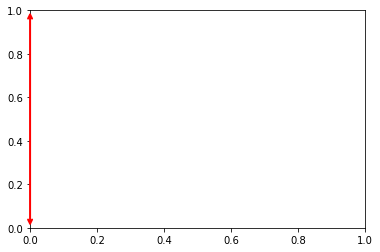

In [75]:
plt.gca().annotate('',xy=(0,1),xytext=(0,0),arrowprops=dict(arrowstyle="<->",connectionstyle="arc3", color='r', lw=2))

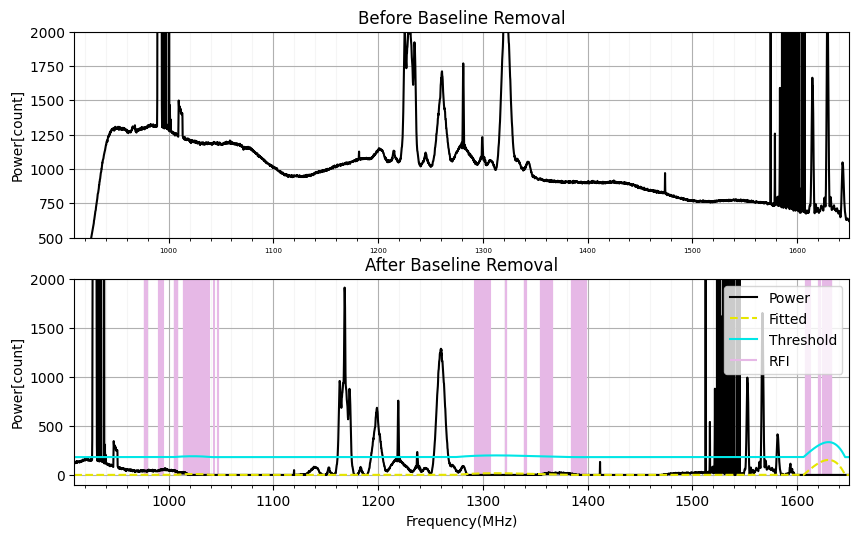

In [57]:
freq,power=wf[0].get_power()
power=np.flip(power)
multi=1.0
f,p,base=rfi.base(wf[0])
test=rfi.intersection(wf[0],multi=multi)
p=np.flip(p)
test=np.flip(test)
plt.figure(figsize=(10,6),dpi=100)
plt.subplot(2,1,1)
plt.plot(freq,power,'k',label='Before')
plt.ylabel('Power[count]')
plt.xlim(910,1650)
plt.ylim(500,2000)
plt.title('Before Baseline Removal')
plt.xticks(fontsize=5)
plt.gca().xaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(20))
plt.grid()
plt.grid(which='minor',color='whitesmoke')
plt.subplot(2,1,2)
plt.plot(f,p,'k',label='Power')
plt.plot(f,base,color='#e6e600',linestyle='--',label='Fitted')
plt.vlines(test,0,np.amax(p),'#e6b8e6',label='RFI')
thres=(p-base).std()*multi/10
plt.plot(f,base+thres,'#00e6e6',label='Threshold')
plt.ylim(-100,2000)
plt.xlim(910,1650)
plt.xlabel('Frequency(MHz)')
plt.ylabel('Power[count]')
plt.title('After Baseline Removal')
plt.gca().xaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(20))
plt.grid()
plt.grid(which='minor',color='whitesmoke')
plt.legend(loc='upper right')
plt.savefig('/mnt/f/Courses/SURP/rfi_poster.pdf')

In [100]:
len(wf)

45

In [8]:
wf[-1].info()


--- File Info ---
      machine_id :                               20
    telescope_id :                               -1
       data_type :                                1
            fch1 :                        856.0 MHz
            foff :                  0.208984375 MHz
          nchans :                             3584
     source_name :                       J0835-4510
         src_raj :                       8:26:01.91
         src_dej :                      -47:14:54.5
        az_start :                              0.0
        za_start :                              0.0
           nbits :                               32
   tstart (ISOT) :          2020-07-16T15:27:21.000
    tstart (MJD) :                59046.64399305556
           tsamp :              0.00979977570093458
            nifs :                                1

Num ints in file :                              548
      File shape :                   (548, 1, 3584)
--- Selection Info ---
Data selection shape 

In [10]:
250*wf[-1].header['foff']

52.24609375

In [11]:
wf

[Waterfall data: data/BR/guppi_58934_57411_004556_Unknown_0001-ics.rawspec.0000.combined.fil,
 Waterfall data: data/BR/guppi_58934_57452_004558_Unknown_0001-ics.rawspec.0000.combined.fil,
 Waterfall data: data/BR/guppi_58934_59184_004644_Unknown_0001-ics.rawspec.0000.combined.fil,
 Waterfall data: data/BR/guppi_58934_61159_004742_Unknown_0001-ics.rawspec.0000.combined.fil,
 Waterfall data: data/BR/guppi_58934_62505_004810_Unknown_0001-ics.rawspec.0000.combined.fil,
 Waterfall data: data/BR/guppi_58934_62544_004811_Unknown_0001-ics.rawspec.0000.combined.fil,
 Waterfall data: data/BR/guppi_58934_63309_004850_Unknown_0001-ics.rawspec.0000.combined.fil,
 Waterfall data: data/BR/guppi_58934_63353_004852_Unknown_0001-ics.rawspec.0000.combined.fil,
 Waterfall data: data/BR/guppi_58934_64435_004906_Unknown_0001-ics.rawspec.0000.combined.fil,
 Waterfall data: data/BR/guppi_58934_64474_004908_Unknown_0001-ics.rawspec.0000.combined.fil,
 Waterfall data: data/BR/guppi_58934_64879_004928_Unknown_00